# CS235F24 Assignment 2

**Dataset:** Airbnb

## Abstract
This project heavily rely on data manipulation while model implement is a small portion. I have tried different method to preprocess data and make them easy to be processed by models. The airbnb price at different location shares different distribution. Thus, make the location as one of the faeture to predict price.

Model used: 4 layers Neuron network, ensemble random forest regressor, Xgboost

# Imports

In [1]:
# [INSERT CODE TO IMPORT NECESSARY PYTHON PACKAGES HERE]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns


# 0. Load Data / Data Exploration

In [2]:
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')

<ipython-input-2-205a7c7efff0>:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  trainDF = pd.read_csv('train.csv')


Take look each columns in the trainDF and a sample of datapoints. Get to know the value range, format and dtypes.

Not using trainDF.head() since it truncted middle columns

In [3]:
coltrain = trainDF.columns
print(coltrain,"\n")

for coltype in coltrain:
  head = trainDF[coltype].loc[1:5]
  print(coltype,"\n",head)
  print("************\n")


Index(['id', 'name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'country_code', 'country', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_ch

## Consider revlent categorical columns and convert them in to processble(numerical) feature.

With my personal common sense, I consider location has strong influence on the price of a living place. In practical to determine signficant feature should be obtained by a more mathmatical approach, such as box-ploting each feature.

While many columns can tell the location information, the "city" has minimum NaN cell (trainDF["city"].isna().sum())

In [4]:
# Take look how many cities are there
print(trainDF['city'].unique())

['New York' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Rego Park'
 'Clinton Hill Brooklyn' 'Manhattan' 'Brooklyn ' 'NYC' 'Astoria '
 'New York City ' 'Ridgewood' 'Jamaica ' 'Maspeth' 'Fresh Meadows '
 'Long Island city ' 'Astoria' 'New York City' 'Williamsburg' nan
 'Staten Island ' 'flushing' 'Jamaica' 'Bronx ' ' Brooklyn'
 'Long Island City' 'Rockaway Beach' 'Middle Village' 'brooklyn'
 'Elmhurst' 'Brookyn ' 'Corona ' 'New York ' 'Bronx, NY'
 'Springfield Gardens' 'Flushing ' 'Glendale ' 'Queens ' 'Flushing'
 'Astoria - New York' 'LONG ISLAND CITY' 'New york' 'brooklyn '
 'Elmhurst ' 'Bayside' 'New-York' 'Far Rockaway ' 'Arverne' 'Auburndale'
 'Wadsworth Terrace, Manhattan, New York' 'Maspeth ' 'Brooklyn NY '
 'East Elmhurst ' 'Forest Hills ' 'Woodside' 'LIC' 'Fresh Meadows'
 'East Elmhurst (Queens)' 'BRONX' '纽约' 'Kew Gardens' 'Oakland gardens '
 'Yonkers' 'woodside ' 'Ridgewood ' 'East Elmhurst' 'Briarwood' 'Corona'
 'College Point' 'Kew Gardens ' 'Arverne ' 'Jackson heights' 'ast

Unfornately the cities are very messy and inconsistent. A location has many variants due to Typo, differnt input format, and languages such as: [new york, New York, 纽约，Queen, queens, quuen].

To make this featur processable, lets perform preprocessing to normalize the cities with **fuzzywuzzy** libraray.

Notice, **fuzzyuzzy** has some limitation. For example, it may convert Chinese characters such as '布鲁克林' to "New York" which it should be Brooklyn. To improve fuzzywuzzy' accuracy, we first clean some special cases' values manually.


In [5]:
# Create a dictionary to map variations of city names to standard names
city_mapping = {
    'brooklyn,  ny 11221': 'brooklyn',
    '布鲁克林': 'Brooklyn',     # Chinese for Brooklyn
    '纽约': 'New York',         # Chinese for New York
    '纽约市': 'New York City',   # Chinese for New York City
    '新 约克': 'New York',       # Chinese for New York
    '纽约法拉盛':'Flusing'      # Chinese for Flushing
}

# set all to lowercase and remove spaces, eaiser to process
trainDF['city'] = trainDF['city'].str.lower().str.strip()

# replace special cases
trainDF['city'] = trainDF['city'].replace(city_mapping)

# check uniqueness after mannual clean
print(trainDF['city'].unique())

['new york' 'brooklyn' 'queens' 'bronx' 'staten island' 'rego park'
 'clinton hill brooklyn' 'manhattan' 'nyc' 'astoria' 'new york city'
 'ridgewood' 'jamaica' 'maspeth' 'fresh meadows' 'long island city'
 'williamsburg' nan 'flushing' 'rockaway beach' 'middle village'
 'elmhurst' 'brookyn' 'corona' 'bronx, ny' 'springfield gardens'
 'glendale' 'astoria - new york' 'bayside' 'new-york' 'far rockaway'
 'arverne' 'auburndale' 'wadsworth terrace, manhattan, new york'
 'brooklyn ny' 'east elmhurst' 'forest hills' 'woodside' 'lic'
 'east elmhurst (queens)' 'New York' 'kew gardens' 'oakland gardens'
 'yonkers' 'briarwood' 'college point' 'jackson heights' 'bronx ny'
 'brooklyn,park slope' 'williamsburg,brooklyn' 'astoria, queens'
 'crown heights,ny' 'rosedale' 'greenpoint' 'riverdale' 'parkchester'
 'elmhurst queens' 'queens village' 'park slope, brooklyn' 'bklyn ny'
 'jackson heights, queens' 'ozone park' 'queens,ny' 'south ozone park'
 'longislandcity' 'whitestone' 'sunnyside' 'south richm

## Implement Fuzzywuzzy to perform entitly matching, further group similar locations togethers(continue entity matching)

In [6]:
!pip install fuzzywuzzy

In [7]:
from fuzzywuzzy import process

# Define an expanded list of known city names (standardized names)
known_cities = [
    "New York", "Brooklyn", "Queens", "Bronx", "Staten Island",
    "Manhattan", "Astoria", "Williamsburg", "Long Island City",
    "Jamaica", "Flushing", "Greenpoint", "Harlem", "Park Slope",
    "Bushwick", "Ridgewood", "Jackson Heights", "Forest Hills",
    "Woodside", "Sunnyside", "Rockaway Beach", "Elmhurst",
    "Bedford-Stuyvesant", "Far Rockaway", "Corona", "Kew Gardens",
    "Bayside", "Richmond Hill", "Ozone Park", "East Elmhurst",
    "Whitestone", "College Point", "South Ozone Park", "Maspeth",
    "Briarwood", "Rosedale", "Bellerose", "Howard Beach",
    "East New York", "Canarsie", "Bay Ridge", "Coney Island",
    "Bay Terrace", "Sheepshead Bay"
]

# normalize 'city' column with fuzzywuzzy to perform match entities
trainDF['city_normalized'] = trainDF['city'].apply(lambda x: process.extractOne(x, known_cities)[0] if pd.notnull(x) else x)




/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [8]:
trainDF['city_normalized'].unique()

array(['New York', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island',
       'South Ozone Park', 'Manhattan', 'Sunnyside', 'Astoria',
       'Ridgewood', 'Jamaica', 'Maspeth', 'Forest Hills',
       'Long Island City', 'Williamsburg', nan, 'Flushing',
       'Rockaway Beach', 'Richmond Hill', 'Elmhurst', 'Corona',
       'Kew Gardens', 'Rosedale', 'Bayside', 'Far Rockaway',
       'East Elmhurst', 'Woodside', 'Coney Island', 'Briarwood',
       'College Point', 'Jackson Heights', 'Greenpoint', 'Park Slope',
       'Ozone Park', 'Whitestone', 'Bellerose', 'East New York',
       'Howard Beach', 'Harlem', 'Bushwick', 'Bedford-Stuyvesant',
       'Sheepshead Bay'], dtype=object)

In [9]:
# Back up the the preprocessed dataset in case made mistakes on the trainDF. Wuzzyfuzzy take a lot of time to match entities.
trainDF_backup = trainDF.copy()


In [10]:
# trainDF = trainDF_backup
# trainDF

## Implement outlier removing(Does not work in this case, do not implement)
After normalized the city column, the total of unique cities is acceptable. Next, we going to remove outliers with IQR method

some notes: The outlier remove significantly helps models to converge faster and stable on the train.csv with final rmse = 45~55. However, when I ran the test.csv and upload to kaggle, the score = 101.

I suspect its due to New York is a "economy-diversity" place. The living places price range is very sparse, ranged from 0 ~ 2000$. If we implement outlier remover with IQR w.r.t to price, 10% of the datapoints will be removed. The outliers in this dataset should not be simply removed with IQR, since they are not outliers, they just strangely reasonable priced.

Particular, some of airbnb is friendly to visitors while some of airbnb are luxury. The luxury airbnb significantly increased the average and increased standard deviation resulted these economic airbnbs outside the IQR the prices are 0 or very low, IQR would remove the portion of datapoints. The price distribution is not a typical gaussian distribution.


In [11]:
# # find the 25 and 75 th percentile
# Q1 = trainDF.groupby('city_normalized')['price'].transform(lambda x: x.quantile(0.25))
# Q3 = trainDF.groupby('city_normalized')['price'].transform(lambda x: x.quantile(0.75))
# IQR = Q3 - Q1

# # remove datapoints outside +-1.5 IQR range
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # filtering
# trainDF = trainDF[(trainDF['price'] >= lower_bound) & (trainDF['price'] <= upper_bound)]


# plt.figure(figsize=(10, 10))
# sns.boxplot(data=trainDF, x='city_normalized', y='price')
# plt.xticks(rotation=90)
# plt.title("airbnb price vs city(outliers removed)")
# plt.xlabel("City")
# plt.ylabel("Price")
# plt.show()


## box Plot for the prices according to their city location

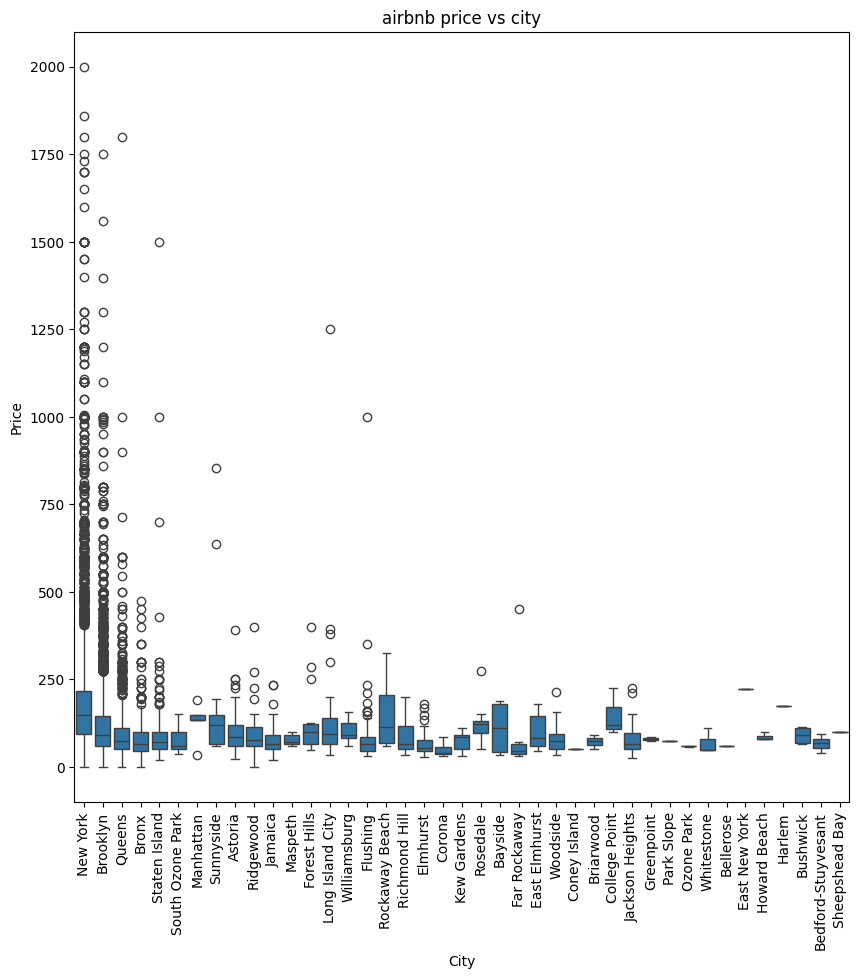

In [12]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=trainDF, x='city_normalized', y='price')
plt.xticks(rotation=90)
plt.title("airbnb price vs city")
plt.xlabel("City")
plt.ylabel("Price")
plt.show()

different cities' airbnb price vary signnificantly. Thus, location can be a good feature.

## Catergorical value encoding
Despite location is a good feature, however it is in the categarical value, to make them processble by model, we can try
1. one-hot coding. This is a good idea since it seperate cities into distinct classes. However, vector form can be computational expensive especially we have so many unique cities.

2. convert to numbers such as 1 for new york,2 for queens,3 for brooklyn. This can yield math meaning, since 2 is larger than 1 may make the models think locations has mathmatically relationships.

3. catergorical value encoding is used in this project. Find the median price for each unique city, then create a new column and assign the median price accordingly. This may lose generality, but its easy to implement and computational cheaper compare to one-hot.

to start:
create a dictionary which has the key = city, and value = the median for each unique city group.

Create a new column: city_median_price, fill the column with the median according to their city_normalized column

In [13]:
# find the median price for each city
city_median_price = trainDF.groupby('city_normalized')['price'].median()

#  use a dictionary from the median values, easier to map
city_price_dict = city_median_price.to_dict()

# create the column: city_median_price. Assign the median from city_price_dict with mapped city_normalized
trainDF['city_median_price'] = trainDF['city_normalized'].map(city_price_dict)


## Next, Perform a data visulization about numerical features.
Take look how features correlated with our target, Help us to see and choose what are good feature candidates. The city_price_median shows a correlationship with the price with correlation at 0.3.

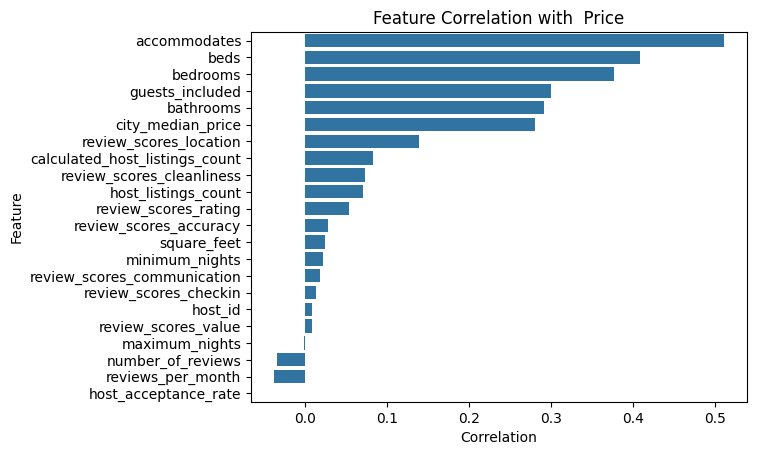

In [14]:
# The target training set
target = trainDF['price']
# select the numerical features, drop the target columns and irrevelent columns such as id
numerical_columns = trainDF.select_dtypes(include=['number']).columns.drop(['price', 'id'])

# fill NaN with the median value of each column. Filling NaN with median can cause data lose veracity, however, process with NaN may cause crash
trainDF[numerical_columns] = trainDF[numerical_columns].fillna(trainDF[numerical_columns].median())

# calculate correlations with 'price'
correlations = trainDF[numerical_columns].corrwith(target).sort_values(ascending=False)


sns.barplot(x=correlations.values, y=correlations.index)
plt.title("Feature Correlation with  Price")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()




# 1. Model Training (30 points)

Train at least 3 models. You may test more than 3 models and apply your own cross-validation approach to choose the top three models to submit to Kaggle. You should include a section

**feature selection:**
select the most correlated features, and perform some preprocess such as fill NaN to ensure model's stability


In [15]:
# use rmse as the metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Select the top few(15) most correlated features with price
selected_features = correlations.index[:10]#modify to desired number of features
print("selected features:", selected_features)

# Prepare data with the selected features
X = trainDF[selected_features]
y = trainDF['price']

# initialize the scaler from sklearn, Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

selected features: Index(['accommodates', 'beds', 'bedrooms', 'guests_included', 'bathrooms',
       'city_median_price', 'review_scores_location',
       'calculated_host_listings_count', 'review_scores_cleanliness',
       'host_listings_count'],
      dtype='object')


In [16]:
# X_train[0],
# len(X_train[0]),
# X_train.shape,
# y_train.shape


**First model: Multi-layer neural network**

In [17]:
# Define a more complex neural network model with dropout. Dropout helps regulate updating strength, prevent from overfitting
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model with a reduced learning rate. Despite the
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=[rmse])

# Use the Model.fit method to  minimize the loss and save the training history(loss, validation accuracy)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=100, verbose=0)

# evaluate on the validation set
val_loss, val_rmse = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss:", val_loss)
print("Validation rmse:", val_rmse)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 9163.0322265625
Validation rmse: 86.94223022460938


## Make predictions on the test.csv
The training and validation on neural network looks good(val_rmse around 85). Lets do dataset alignment for the test.csv with the preoprocesses steps implemented on train.csv, which included:
1. Manual city mapping for special cases such as chinese character
2. apply wuzztfuzzy to further match typo/variant cities into a same group
3. Create the city_median_price, fill with up with the appropriate price according to the city location
4. simple scalar to normalize/standradize training features with sklearn

In [18]:
def preprocess_test_data(test_df, known_cities, city_median_price, top_features, scaler):
    # Define a city mapping for known city name variations
    city_mapping = {
        'Williamsburg Brooklyn': 'Williamsburg',
        '布鲁克林': 'Brooklyn',     # Chinese for Brooklyn
        '纽约': 'New York',         # Chinese for New York
        '纽约市': 'New York City',   # Chinese for New York City
        '新 约克': 'New York',       # Chinese for New York City
        '纽约法拉盛': 'Flushing'    # Chinese for Flushing
    }

    # set all to lowercase and remove spaces, eaiser to process
    test_df['city'] = test_df['city'].str.lower().str.strip()  # Convert to lowercase and remove whitespace

    # replace special cases
    test_df['city'] = test_df['city'].replace(city_mapping)

    # normalize 'city' column with fuzzywuzzy to perform match entities
    test_df['city_normalized'] = test_df['city'].apply(lambda x: process.extractOne(x, known_cities)[0] if pd.notnull(x) else x)

    # create the column with the same name as training, map with training set's median
    test_df['city_median_price'] = test_df['city_normalized'].map(city_median_price)


    # For the missing values in the test.csv, replace them with the median from training set to ensure consistency
    numerical_columns = top_features  # borrow features selected from training data
    test_df[numerical_columns] = test_df[numerical_columns].fillna(trainDF[numerical_columns].median()) # fill the NaN

    # Select only the top features from the test data
    X_test = test_df[top_features]

    # Scale the features
    X_test_scaled = scaler.transform(X_test)

    return X_test_scaled

In [19]:
# preprocess the testset's data
X_test_scaled = preprocess_test_data(testDF, known_cities, city_median_price, selected_features, scaler)

# Make predictions on test set
predictions = model.predict(X_test_scaled)

# exporting to csv file
predictions_df = pd.DataFrame({'id': testDF['id'], 'price': predictions.flatten()})
predictions_df.to_csv('pricesNN.csv', index=False)


210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Model2 Xgboost
examples: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

https://xgboost.readthedocs.io/en/stable/get_started.html

Ridge regression.
https://machinelearningmastery.com/ridge-regression-with-python/

In [20]:
# Model 2
# Rigde regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# define/initialize the Ridge Regression model
ridge_model = Ridge(alpha=0.8)  # aplha = 1 is at the full(default) penality.
ridge_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_ridge = ridge_model.predict(X_val)

# calculate RMSE by setting squared = False. evaluate for the validation set
rmse_ridge = mean_squared_error(y_val, y_pred_ridge, squared=False)
print("Ridge Regression RMSE:", rmse_ridge)

# Make predictions on test set
ridge_test_predictions = ridge_model.predict(X_test_scaled)

# exporting to csv file
ridge_predictions_df = pd.DataFrame({'id': testDF['id'], 'price': ridge_test_predictions})
ridge_predictions_df.to_csv('ridge_regression_price.csv', index=False)
print("ridge_regression finshed")


Ridge Regression RMSE: 104.52814133216226
ridge_regression finshed


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ridge regression model performence is relatively bad. With Rmse around 104

**Lets try Xgboost**
it can be a good option since it handle more complex features(non0_linear replationships) and adaptive on features while ridge regression's strength is on linear relationships


In [21]:
from xgboost import XGBRegressor

# define and initialize and xgboost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, eval_metric='rmse')
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# track the epoch loss
xgb_rmse = xgb_model.evals_result()['validation_0']['rmse']

# Predict on the validation set
y_pred_xgb = xgb_model.predict(X_val)

# calculate RMSE by setting squared = False. evaluate for the validation set
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
print("XGBoost RMSE:", rmse_xgb)

# Make predictions on the test set
xgb_test_predictions = xgb_model.predict(X_test_scaled)

# exporting to csv file
xgb_predictions_df = pd.DataFrame({'id': testDF['id'], 'price': xgb_test_predictions})
xgb_predictions_df.to_csv('xgboost_Price.csv', index=False)
print("XGBoost finished")


XGBoost RMSE: 92.30508646626181
XGBoost finished


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Model3 randomForest

As lecture discussed, its an ensemble method, it do handles complex non-linear relationships. Despite it is mainly handle small dataset. As we increase the n_estimator and max_depth, enhance the models ability for large complex dataset. The result is good too.
https://machinelearningmastery.com/random-forest-ensemble-in-python/

In [22]:
# Model 3 ensemble random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# define and initialize the Random Forest with regressor for continous numerical model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_model.predict(X_val)

# Calculate and print RMSE for the validation set
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
print("Random Forest RMSE:", rmse_rf)

# Make predictions on the test set
rf_test_predictions = rf_model.predict(X_test_scaled)

# exporting to csv file
rf_predictions_df = pd.DataFrame({'id': testDF['id'], 'price': rf_test_predictions})
rf_predictions_df.to_csv('random_forestReg_price.csv', index=False)
print("Random Forest finished")


Random Forest RMSE: 94.32370753731887
Random Forest finished


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 2. Plotting (10 points)

**RMSE value across models**

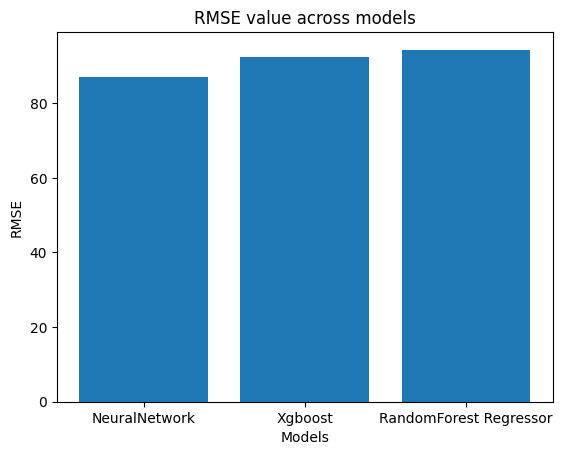

In [29]:
# Define model names and their respective RMSE values
methods = ['NeuralNetwork', 'Xgboost', 'RandomForest Regressor']
rmse_values = [val_rmse, rmse_xgb, rmse_rf]  # Replace 'val_rmse' with the final RMSE from NN

# Create the bar plot
plt.bar(methods, rmse_values)

# Add plot details
plt.title('RMSE value across models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()


**Learning Curve for Neural network**

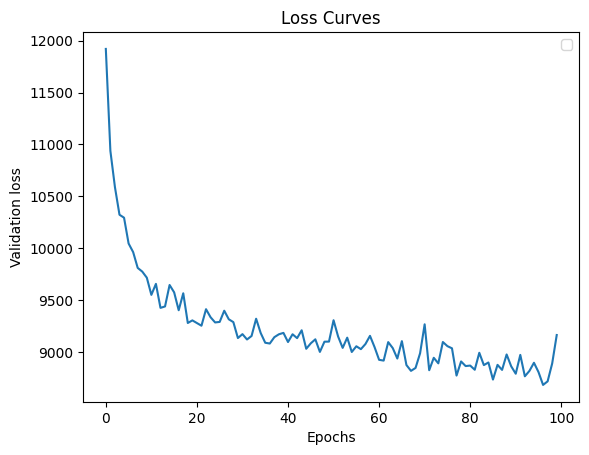

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()


**Learning Curve for Xgboost**

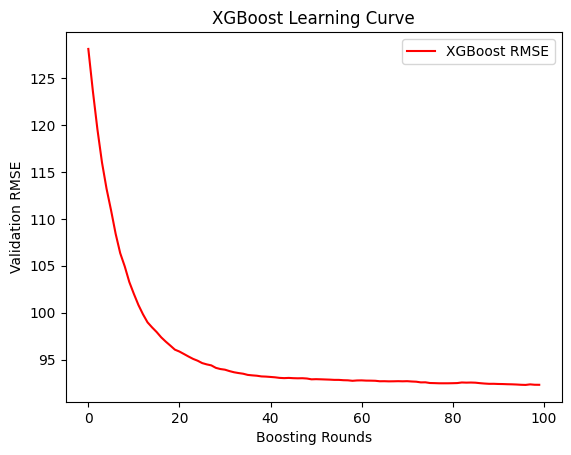

In [25]:
plt.plot(xgb_rmse, label='XGBoost RMSE', color='red')
plt.title('XGBoost Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.legend()
plt.show()


**important features for Random Forest**

In [26]:
importances = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

print(rf_feature_importance)


                          Feature  Importance
0                    accommodates    0.381375
4                       bathrooms    0.159550
5               city_median_price    0.144467
2                        bedrooms    0.081112
9             host_listings_count    0.061235
3                 guests_included    0.043797
6          review_scores_location    0.041232
7  calculated_host_listings_count    0.038158
1                            beds    0.026244
8       review_scores_cleanliness    0.022828


# 3. Discussion (10 points)


1. Neural Network:

The Neural Network's validation RMSE decreases significantly during the early epochs around  20. Afterward the decrement persist but slows down and fluctuating. The Neural Network do converges, but sentive to outliers. With adam optimizer to update learning rate slightly deal with this issue and continue to minimize loss slowly. Final RMSE around 86

2. XGBoost:

The XGBoost RMSE has the lowest RMSE around 93. Unlike neural network, the learning curve(loss) is smoothy and converge faster at early stage. This result shows that Xgboost effectively handle complex and non-linear relationships of data. Since its ensemble and gradient boosting algorithmn.

3. Random Forest:

The Random Forest Regressor's RMSE remains constant around 94, as its tree structure does not need iterative training like the regression models. This result shows that random forest regressor is effective with extensive hyperparameter tuning.

4. Observation and Attempts:

At the early training epochs: The Neural Network initially performs worse compare to XGBoost but gradually catches up.
Final result: Neural Network achieves the best RMSE, followed closely by the XGBoost , while Random Forest slightly lags.
Model Suitability:
The Neural Network is effective but rely on many layers and neurons to scale its complexity and took 2min to train while Xgboost and Random forest just few seconds.
Random Forest is robust and simpler to implement but may underperform compared to advanced techniques like Xgboost.
Xgboost combines computation efficent and flexibility, making it should be a good model in this case.

5. Attempts:

Despite models loss error varies, but the differences among models are small around 5%. If we Train models with all numerical features without preprocessing and selection, the neural network has loss around 101, and xgboos and ensemble random forefost regressor has the RMSE aroun 104. After preprocessing, all 3 models had a significant decrease in their loss.

However, not all preprocessing technics are good. For instance, removing outliters do helps the model doing well on training set, but make predictions on validation set resulted a very high rmse. The outlier are almost 15% of the total samples since the price distribution is skewed and not standrad.

Also, choosing a complex and appropriate algorithm is important. With the ridge-regression model, it has strength about linear relationship, but in this project, many of features important and not linearly related. Thus ridge regression has a poor performence.

To construct a meaningful result and discover informative pattern is a combination of many technics. Data collection, data preprocess, model selection and training and many mindful skills play critical roles.

# References / Disclosure


easy to use models: https://medium.com/@mehmetalitor/top-15-machine-learning-regression-algorithms-2cf128c8935e

sklearn models: https://scikit-learn.org/stable/supervised_learning.html

xgboost: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

Ensemble Random Forest: https://machinelearningmastery.com/random-forest-ensemble-in-python/